# Libraries

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set all random seeds
np.random.seed(42)
import random
random.seed(42)

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\johnt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johnt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

First few rows of training set:
        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intellig

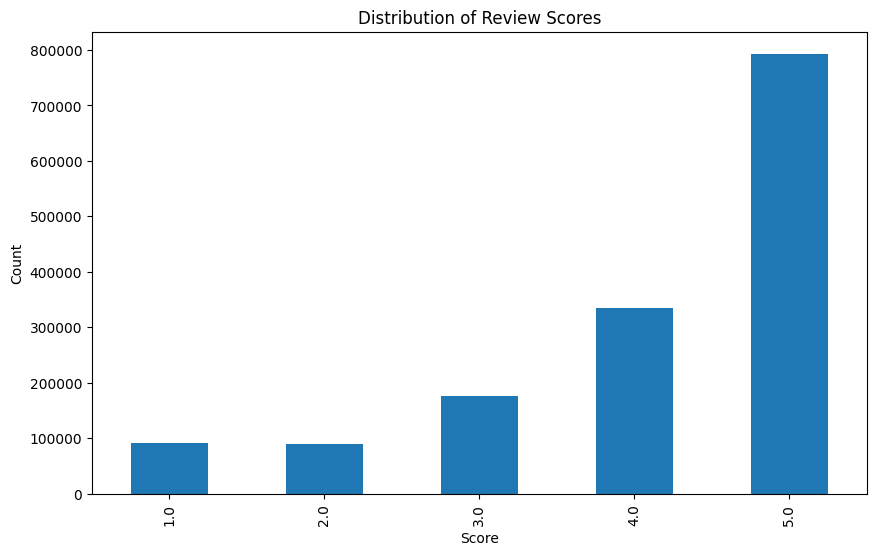

In [12]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print("\nFirst few rows of training set:")
print(trainingSet.head())
print("\nFirst few rows of test set:")
print(testingSet.head())

print("\nTraining set statistics:")
print(trainingSet.describe())

# Plot score distribution
plt.figure(figsize=(10, 6))
trainingSet['Score'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Adding Features

In [13]:
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [t for t in tokens if t not in stop_words]
        return ' '.join(tokens)
    return ''

def add_features_to(df):
    # Text length features
    df['text_length'] = df['Text'].fillna('').apply(len)
    df['summary_length'] = df['Summary'].fillna('').apply(len)
    
    # Helpfulness ratio with handling division by zero
    df['helpfulness_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'].replace(0, 1)
    df['helpfulness_ratio'] = df['helpfulness_ratio'].fillna(0)
    
    # User statistics
    user_stats = df.groupby('UserId').agg({
        'Score': ['mean', 'count']
    }).fillna(0)
    user_stats.columns = ['user_avg_score', 'user_review_count']
    df = df.merge(user_stats, left_on='UserId', right_index=True, how='left')
    
    # Product statistics
    product_stats = df.groupby('ProductId').agg({
        'Score': ['mean', 'count']
    }).fillna(0)
    product_stats.columns = ['product_avg_score', 'product_review_count']
    df = df.merge(product_stats, left_on='ProductId', right_index=True, how='left')
    
    # Text preprocessing
    df['processed_text'] = df['Text'].fillna('').apply(preprocess_text)
    
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    
    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    
    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]
    
    # Save processed datasets
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [14]:
# Split training set into training and testing set
X_train_split, X_test_split, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=42
)

# Feature Selection

In [19]:
# Select features for modeling
feature_columns = [
    'text_length', 'summary_length', 'helpfulness_ratio',
    'user_avg_score', 'user_review_count',
    'product_avg_score', 'product_review_count'
]#calculate these

# Create TF-IDF features with fixed random state
tfidf = TfidfVectorizer(
    max_features=1000, 
    ngram_range=(1, 2),
)

# Get feature importance using a simple model
X_train_select = X_train_split[feature_columns]
X_test_select = X_test_split[feature_columns]
X_submission_select = X_submission[feature_columns]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_select)
X_test_scaled = scaler.transform(X_test_select)
X_submission_scaled = scaler.transform(X_submission_select)

# Train a model to get feature importance
rf_feature = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature.fit(X_train_scaled, Y_train)

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_feature.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()

KeyError: "None of [Index(['text_length', 'summary_length', 'helpfulness_ratio', 'user_avg_score',\n       'user_review_count', 'product_avg_score', 'product_review_count'],\n      dtype='object')] are in the [columns]"

# Model Creation

In [20]:
# Create and train the final model with fixed random state
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'
)

model.fit(X_train_scaled, Y_train)

# Model Evaluation

In [ ]:
# Make predictions
Y_test_predictions = model.predict(X_test_scaled)

# Calculate accuracy
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [23]:
# Create the submission file
submission = pd.DataFrame({
    'Id': X_submission['Id'],
    'Score': model.predict(X_submission_scaled)
})

submission.to_csv("./data/submission.csv", index=False)
print("Submission file created successfully!")